In [144]:
import geopandas
import matplotlib.pyplot as mp
import cartopy
import numpy
import xarray
import cmocean
import rasterio

In [167]:
ca_eco_l3 = geopandas.read_file('../ca_eco_l3/ca_eco_l3.shp')

In [149]:
ca_eco_l3.head()

,US_L3CODE,US_L3NAME,NA_L3CODE,NA_L3NAME,NA_L2CODE,NA_L2NAME,NA_L1CODE,NA_L1NAME,STATE_NAME,EPA_REGION,L3_KEY,L2_KEY,L1_KEY,geometry
0,1,Coast Range,7.1.8,Coast Range,7.1,MARINE WEST COAST FOREST,7,MARINE WEST COAST FOREST,California,10,1 Coast Range,7.1 MARINE WEST COAST FOREST,7 MARINE WEST COAST FOREST,(POLYGON ((-2284145.645799998 1942003.85980000...
1,13,Central Basin and Range,10.1.5,Central Basin and Range,10.1,COLD DESERTS,10,NORTH AMERICAN DESERTS,California,10,13 Central Basin and Range,10.1 COLD DESERTS,10 NORTH AMERICAN DESERTS,"(POLYGON ((-1856589.398599999 1762342.1763, -1..."
2,14,Mojave Basin and Range,10.2.1,Mojave Basin and Range,10.2,WARM DESERTS,10,NORTH AMERICAN DESERTS,California,9,14 Mojave Basin and Range,10.2 WARM DESERTS,10 NORTH AMERICAN DESERTS,"POLYGON ((-1899479.7774 1806588.553400001, -18..."
3,4,Cascades,6.2.7,Cascades,6.2,WESTERN CORDILLERA,6,NORTHWESTERN FORESTED MOUNTAINS,California,10,4 Cascades,6.2 WESTERN CORDILLERA,6 NORTHWESTERN FORESTED MOUNTAINS,POLYGON ((-2131525.308100002 2400780.837399999...
4,5,Sierra Nevada,6.2.12,Sierra Nevada,6.2,WESTERN CORDILLERA,6,NORTHWESTERN FORESTED MOUNTAINS,California,9,5 Sierra Nevada,6.2 WESTERN CORDILLERA,6 NORTHWESTERN FORESTED MOUNTAINS,"POLYGON ((-2069803.4551 2205701.5616, -2069451..."


In [154]:
sierras_series = ca_eco_l3.loc[4,:]

In [166]:
type(sierras_series.geometry)

shapely.geometry.polygon.Polygon

In [155]:
states_shapes = cartopy.io.shapereader.natural_earth(resolution='10m', category='cultural', name='admin_1_states_provinces')
shapes_reader = cartopy.io.shapereader.Reader(states_shapes)

states_name_list = numpy.array(([i.attributes['name'] for i in shapes_reader.records()]))
for i in shapes_reader.records():
    if i.attributes['name']=='California' and i.attributes['iso_a2']=='US':
        CA_object = i
CA_object_no_islands = CA_object.geometry.geoms[-1] # get the last one (the state of Cali)


In [156]:
lon_lo, lon_hi, lat_lo, lat_hi = 235.25, 246.25, 32., 42.5

In [157]:
# topographic data
filename = '/Users/baird/Dropbox/_group_conferences/2017/agu_2017/upgoer_5/code_for_plots/noaa_topo_data/ETOPO1_Ice_g_gmt4.grd'

ncfile = xarray.open_dataset(filename)
ncfile['x']+=360.
topo_data = ncfile['z'].sel(y=slice(lat_lo,lat_hi),x=slice(lon_lo,lon_hi)).values
topo_lat = ncfile['y'].sel(y=slice(lat_lo,lat_hi)).values
topo_lon = ncfile['x'].sel(x=slice(lon_lo,lon_hi)).values


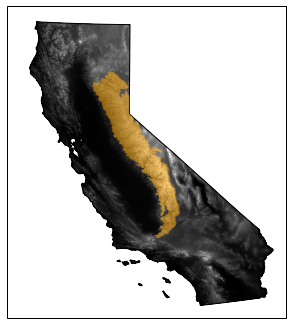

In [158]:
fig = mp.figure(figsize=(5,10))

map_proj = cartopy.crs.LambertConformal(standard_parallels=[lat_lo,lat_hi], \
    central_longitude=0.5*(lon_lo+lon_hi), \
    central_latitude=0.5*(lat_lo+lat_hi))

data_proj = cartopy.crs.AlbersEqualArea(central_longitude=-96.0, \
                            central_latitude=23.0, \
                            false_easting=0.0, \
                            false_northing=0.0, \
                            standard_parallels=(29.5, 45.5), \
                            globe=None)

# From xml file included with shapefile info:
#
# USA Contiguous Albers Equal Area Conic USGS version</mapprojn>
# <albers>
# <stdparll>29.5</stdparll>
# <stdparll>45.5</stdparll>
# <longcm>-96.0</longcm>
# <latprjo>23.0</latprjo>
# <feast>0.0</feast>
# <fnorth>0.0</fnorth>

ax = fig.add_subplot(111, projection=map_proj)
#ax.coastlines(resolution='50m')
ax.set_extent([lon_lo, lon_hi, lat_lo, lat_hi])

ax.add_geometries(CA_object.geometry, crs=cartopy.crs.PlateCarree(), facecolor='None', edgecolor='0')

ax.add_geometries([sierras_series.geometry], crs=data_proj, facecolor='orange', alpha=0.5)

vmin, vmax = -100., 4000.
state_paths = cartopy.mpl.patch.geos_to_path(CA_object.geometry)
for i in range(len(state_paths)):
    topo_image = ax.pcolormesh(topo_lon, topo_lat, topo_data, vmin=vmin, vmax=vmax, cmap=cmocean.cm.gray, transform=cartopy.crs.PlateCarree())
#     #topo_image = ax.contourf(topo_lon_subset, topo_lat_subset, topo_data_subset, levels=levels, extend='both', cmap='magma', transform=cartopy.crs.PlateCarree())
    topo_image.set_clip_path(state_paths[i], transform=cartopy.crs.PlateCarree()._as_mpl_transform(ax))
#topo_image = ax.pcolormesh(topo_lon, topo_lat, topo_data, vmin=vmin, vmax=vmax, cmap='magma', transform=cartopy.crs.PlateCarree())

# states_provinces = cartopy.feature.NaturalEarthFeature(
# category='cultural',
# name='admin_1_states_provinces_lines',
# scale='10m',
# facecolor='none')

# countries = cartopy.feature.NaturalEarthFeature(
# category='cultural',
# name='admin_0_countries',
# scale='10m',
# facecolor='none')

#ax.add_feature(states_provinces, edgecolor='0')
#ax.add_feature(countries, edgecolor='0')

fig.savefig('topo_and_sierras_ecoregion.png', dpi=600, bbox_inches='tight', transparent=True)

open NetCDF4 CESM LENS data set

In [159]:
ncfile = xarray.open_dataset('../cesm-LE-file/b.e11.B20TRC5CNBDRD.f09_g16.002.cam.h1.TS.19200101-20051231.nc')
ts_data = ncfile['TS'].sel(lat=slice(lat_lo-5,lat_hi+5),lon=slice(lon_lo-5,lon_hi+5)).values
ts_lat = ncfile['lat'].sel(lat=slice(lat_lo-5,lat_hi+5)).values
ts_lon = ncfile['lon'].sel(lon=slice(lon_lo-5,lon_hi+5)).values

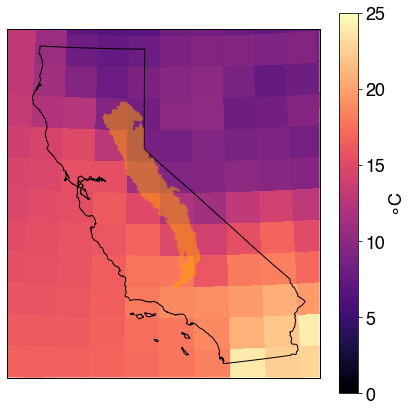

In [160]:
fig = mp.figure(figsize=(7,7))

map_proj = cartopy.crs.LambertConformal(standard_parallels=[lat_lo,lat_hi], \
    central_longitude=0.5*(lon_lo+lon_hi), \
    central_latitude=0.5*(lat_lo+lat_hi))

data_proj = cartopy.crs.AlbersEqualArea(central_longitude=-96.0, \
                            central_latitude=23.0, \
                            false_easting=0.0, \
                            false_northing=0.0, \
                            standard_parallels=(29.5, 45.5), \
                            globe=None)

lens_proj = cartopy.crs.PlateCarree()

ax = fig.add_subplot(111, projection=map_proj)
ax.set_extent([lon_lo, lon_hi, lat_lo, lat_hi])

ax.add_geometries(CA_object.geometry, crs=cartopy.crs.PlateCarree(), facecolor='None', edgecolor='0')
ax.add_geometries([sierras_series.geometry], crs=data_proj, facecolor='orange', alpha=0.5)

lon_pcolormesh = numpy.zeros(ts_lon.size+2)
lon_pcolormesh[1:-1] = ts_lon
lon_pcolormesh[0] = ts_lon[0]-numpy.diff(ts_lon)[0]
lon_pcolormesh[-1] = ts_lon[-1]+numpy.diff(ts_lon)[-1]
lon_pcolormesh_midpoints = lon_pcolormesh[:-1]+0.5*(numpy.diff(lon_pcolormesh))

lat_pcolormesh = numpy.zeros(ts_lat.size+2)
lat_pcolormesh[1:-1] = ts_lat
lat_pcolormesh[0] = ts_lat[0]-numpy.diff(ts_lat)[0]
lat_pcolormesh[-1] = ts_lat[-1]+numpy.diff(ts_lat)[-1]
lat_pcolormesh_midpoints = lat_pcolormesh[:-1]+0.5*(numpy.diff(lat_pcolormesh))

temps = ax.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,ts_data.mean(axis=0)-273.15,\
                      cmap='magma',transform=lens_proj, vmin=0, vmax=25)
cbar = mp.colorbar(temps)
cbar.ax.tick_params(labelsize=18)
cbar.set_label('$\circ$C', fontsize=18)
fig.savefig('temp_and_ecoregion.png', dpi=600, bbox_inches='tight', transparent=True)

In [161]:
latlon_ds = xarray.Dataset(coords={'lat':ts_lat,'lon':ts_lon})

In [162]:
latlon_ds

<xarray.Dataset>
Dimensions:  (lat: 21, lon: 17)
Coordinates:
  * lat      (lat) float64 27.8 28.74 29.69 30.63 ... 43.82 44.76 45.71 46.65
  * lon      (lon) float64 231.2 232.5 233.8 235.0 ... 247.5 248.8 250.0 251.2
Data variables:
    *empty*

In [163]:
# function definitions from Stephan Hoyer
import geopandas
from rasterio import features
from affine import Affine

# takes a lat/lon values in a data array and
# transforms them into the new coord system
def transform_from_latlon(lat, lon):
    lat = numpy.asarray(lat)
    lon = numpy.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

# takes the transformed stuff and rasterizes it
def rasterize(shapes, coords, fill=numpy.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xarray coordinates. This only works for 1d lat and lon
    arrays.
    """
    transform = transform_from_latlon(coords['lat'], coords['lon'])
    out_shape = (len(coords['lat']), len(coords['lon']))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    return xarray.DataArray(raster, coords=coords, dims=('lat', 'lon'))

## this shapefile is from natural earth data
## http://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-1-states-provinces/
# states = geopandas.read_file('/beegfs/DATA/pritchard/blangenb/NATURAL_EARTH_DATA/ne_10m_admin_1_states_provinces')
# states.head()

In [99]:
ca_eco_l3.head()

,US_L3CODE,US_L3NAME,NA_L3CODE,NA_L3NAME,NA_L2CODE,NA_L2NAME,NA_L1CODE,NA_L1NAME,STATE_NAME,EPA_REGION,L3_KEY,L2_KEY,L1_KEY,geometry
0,1,Coast Range,7.1.8,Coast Range,7.1,MARINE WEST COAST FOREST,7,MARINE WEST COAST FOREST,California,10,1 Coast Range,7.1 MARINE WEST COAST FOREST,7 MARINE WEST COAST FOREST,(POLYGON ((-2284145.645799998 1942003.85980000...
1,13,Central Basin and Range,10.1.5,Central Basin and Range,10.1,COLD DESERTS,10,NORTH AMERICAN DESERTS,California,10,13 Central Basin and Range,10.1 COLD DESERTS,10 NORTH AMERICAN DESERTS,"(POLYGON ((-1856589.398599999 1762342.1763, -1..."
2,14,Mojave Basin and Range,10.2.1,Mojave Basin and Range,10.2,WARM DESERTS,10,NORTH AMERICAN DESERTS,California,9,14 Mojave Basin and Range,10.2 WARM DESERTS,10 NORTH AMERICAN DESERTS,"POLYGON ((-1899479.7774 1806588.553400001, -18..."
3,4,Cascades,6.2.7,Cascades,6.2,WESTERN CORDILLERA,6,NORTHWESTERN FORESTED MOUNTAINS,California,10,4 Cascades,6.2 WESTERN CORDILLERA,6 NORTHWESTERN FORESTED MOUNTAINS,POLYGON ((-2131525.308100002 2400780.837399999...
4,5,Sierra Nevada,6.2.12,Sierra Nevada,6.2,WESTERN CORDILLERA,6,NORTHWESTERN FORESTED MOUNTAINS,California,9,5 Sierra Nevada,6.2 WESTERN CORDILLERA,6 NORTHWESTERN FORESTED MOUNTAINS,"POLYGON ((-2069803.4551 2205701.5616, -2069451..."


In [100]:
# loop through each country (country name is SOVEREIGNT, look up via countries.head())
# store in list with country name, row number
ecoregion_rownumbers = {k: i for i,k in enumerate(ca_eco_l3.US_L3NAME)}
# store a list of country shapes
ecoregion_shapes_list = [(shape,n) for n,shape in enumerate(ca_eco_l3.geometry)]

In [101]:
ecoregion_rownumbers

{'Coast Range': 0,
 'Central Basin and Range': 1,
 'Mojave Basin and Range': 2,
 'Cascades': 3,
 'Sierra Nevada': 4,
 'Central California Foothills and Coastal Mountains': 5,
 'Central California Valley': 6,
 'Klamath Mountains/California High North Coast Range': 7,
 'Southern California Mountains': 8,
 'Northern Basin and Range': 9,
 'Sonoran Basin and Range': 10,
 'Southern California/Northern Baja Coast': 11,
 'Eastern Cascades Slopes and Foothills': 12}

In [ ]:
latlon_ds_coords

In [92]:
latlon_ds['ecoregions'] = rasterize(ecoregion_shapes_list, latlon_ds.coords)

In [93]:
latlon_ds.coords

Coordinates:
  * lat      (lat) float64 27.8 28.74 29.69 30.63 ... 43.82 44.76 45.71 46.65
  * lon      (lon) float64 231.2 232.5 233.8 235.0 ... 247.5 248.8 250.0 251.2

In [96]:
sierras_mask = latlon_ds.ecoregions.where(latlon_ds.ecoregions==ecoregion_rownumbers['Sierra Nevada']).values
sierras_mask[~numpy.isnan(sierras_mask)]=1.0

/Users/baird/miniconda3/lib/python3.7/site-packages/matplotlib/colors.py:918: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/Users/baird/miniconda3/lib/python3.7/site-packages/numpy/ma/core.py:718: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


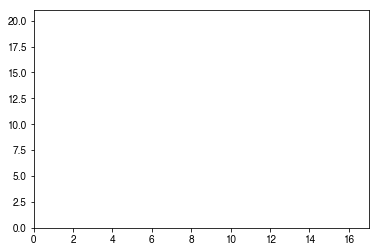

In [97]:
mp.pcolormesh(sierras_mask)

In [95]:
latlon_ds.ecoregions

<xarray.DataArray 'ecoregions' (lat: 21, lon: 17)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 27.8 28.74 29.69 30.63 ... 43.82 44.76 45.71 46.65
  * lon      (lon) float64 231.2 232.5 233.8 235.0 ... 247.5 248.8 250.0 251.2

In [105]:
ncfile

<xarray.Dataset>
Dimensions:       (ilev: 31, lat: 192, lev: 30, lon: 288, nbnd: 2, slat: 191, slon: 288, time: 31390)
Coordinates:
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * lat           (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * lon           (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * slat          (slat) float64 -89.53 -88.59 -87.64 ... 87.64 88.59 89.53
  * slon          (slon) float64 -0.625 0.625 1.875 3.125 ... 355.6 356.9 358.1
  * time          (time) object 1920-01-01 00:00:00 ... 2005-12-31 00:00:00
Dimensions without coordinates: nbnd
Data variables:
    P0            float64 ...
    TS            (time, lat, lon) float32 ...
    ch4vmr        (time) float64 ...
    co2vmr        (time) float64 ...
    date          (time) int32 ...
    date_written  (time) |S8 ...
    datesec       (time) int32 ...
    f11vmr    

In [107]:
ts_lens = ncfile['TS'].isel(time=0)

In [116]:
ca_eco_l3.crs = 

,US_L3CODE,US_L3NAME,NA_L3CODE,NA_L3NAME,NA_L2CODE,NA_L2NAME,NA_L1CODE,NA_L1NAME,STATE_NAME,EPA_REGION,L3_KEY,L2_KEY,L1_KEY,geometry
0,1,Coast Range,7.1.8,Coast Range,7.1,MARINE WEST COAST FOREST,7,MARINE WEST COAST FOREST,California,10,1 Coast Range,7.1 MARINE WEST COAST FOREST,7 MARINE WEST COAST FOREST,(POLYGON ((-2284145.645799998 1942003.85980000...
1,13,Central Basin and Range,10.1.5,Central Basin and Range,10.1,COLD DESERTS,10,NORTH AMERICAN DESERTS,California,10,13 Central Basin and Range,10.1 COLD DESERTS,10 NORTH AMERICAN DESERTS,"(POLYGON ((-1856589.398599999 1762342.1763, -1..."
2,14,Mojave Basin and Range,10.2.1,Mojave Basin and Range,10.2,WARM DESERTS,10,NORTH AMERICAN DESERTS,California,9,14 Mojave Basin and Range,10.2 WARM DESERTS,10 NORTH AMERICAN DESERTS,"POLYGON ((-1899479.7774 1806588.553400001, -18..."
3,4,Cascades,6.2.7,Cascades,6.2,WESTERN CORDILLERA,6,NORTHWESTERN FORESTED MOUNTAINS,California,10,4 Cascades,6.2 WESTERN CORDILLERA,6 NORTHWESTERN FORESTED MOUNTAINS,POLYGON ((-2131525.308100002 2400780.837399999...
4,5,Sierra Nevada,6.2.12,Sierra Nevada,6.2,WESTERN CORDILLERA,6,NORTHWESTERN FORESTED MOUNTAINS,California,9,5 Sierra Nevada,6.2 WESTERN CORDILLERA,6 NORTHWESTERN FORESTED MOUNTAINS,"POLYGON ((-2069803.4551 2205701.5616, -2069451..."
5,6,Central California Foothills and Coastal Mount...,11.1.1,"California Coastal Sage, Chaparral, and Oak Wo...",11.1,MEDITERRANEAN CALIFORNIA,11,MEDITERRANEAN CALIFORNIA,California,9,6 Central California Foothills and Coastal Mo...,11.1 MEDITERRANEAN CALIFORNIA,11 MEDITERRANEAN CALIFORNIA,"(POLYGON ((-2270791.039500002 1930692.3902, -2..."
6,7,Central California Valley,11.1.2,Central California Valley,11.1,MEDITERRANEAN CALIFORNIA,11,MEDITERRANEAN CALIFORNIA,California,9,7 Central California Valley,11.1 MEDITERRANEAN CALIFORNIA,11 MEDITERRANEAN CALIFORNIA,"POLYGON ((-2181481.579299999 2212606.921, -218..."
7,78,Klamath Mountains/California High North Coast ...,6.2.11,Klamath Mountains,6.2,WESTERN CORDILLERA,6,NORTHWESTERN FORESTED MOUNTAINS,California,10,78 Klamath Mountains/California High North Co...,6.2 WESTERN CORDILLERA,6 NORTHWESTERN FORESTED MOUNTAINS,"POLYGON ((-2253964.7863 2442366.586500002, -22..."
8,8,Southern California Mountains,11.1.3,Southern and Baja California Pine-Oak Mountains,11.1,MEDITERRANEAN CALIFORNIA,11,MEDITERRANEAN CALIFORNIA,California,9,8 Southern California Mountains,11.1 MEDITERRANEAN CALIFORNIA,11 MEDITERRANEAN CALIFORNIA,(POLYGON ((-1896547.724799998 1413885.23780000...
9,80,Northern Basin and Range,10.1.3,Northern Basin and Range,10.1,COLD DESERTS,10,NORTH AMERICAN DESERTS,California,10,80 Northern Basin and Range,10.1 COLD DESERTS,10 NORTH AMERICAN DESERTS,POLYGON ((-1955305.929199997 2351546.788000003...


In [114]:
rasterio.mask.mask(ts_lens, sierras_series)

AttributeError: 'DataArray' object has no attribute 'nodata'

In [113]:
import rasterio.mask

In [ ]:
masked_output = rasterio.mask.mask(precip_da.mean(dim="time"), awash)